In [1]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import glob

import deepposekit as dpk

import TrainingGeneratorTFRecord as TGTFR
import apt_dpk 
import run_apt_expts_2 as rae
import APT_interface as apt
import PoseTools as pt
import multiResData as mrd

import time
from os.path import expanduser

import mpl_toolkits.axes_grid1 as axg1

DPK_DSET = '/home/al/git/dpkd/datasets/fly/annotation_data_release.h5'

Using TensorFlow backend.
W0504 21:39:46.409999 140621742061376 deprecation_wrapper.py:119] From /home/al/git/APT_aldl/deepnet/open_pose4.py:12: The name tf.keras.initializers.random_normal is deprecated. Please use tf.compat.v1.keras.initializers.random_normal instead.



Your cache is: /dat0/apt/cache0426
Your models are: ['dpk']


#### Create a DPK DG; create an APT TFR. Confirm that we read the identical ims/locs from both.


In [7]:
dg = dpk.DataGenerator(DPK_DSET)

/dat0/venv/env/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [4]:
LEAPSTRIPPEDLBL = '/dat0/jrcmirror/groups/branson/bransonlab/apt/experiments/data/leap_dataset_gt_stripped.lbl'
EXPNAME = 'dpkfly'
CACHE = '/dat0/apt/cache'
conf = apt.create_conf(LEAPSTRIPPEDLBL, 0, EXPNAME, \
                       CACHE, 'dpkfly', quiet=False)

In [5]:
# Cached images in strippedlbl differ from dpk h5! 
# - Ims are 3-chan grayscale vs 1-chan
# - Locs are off-by-one; strippedlbl prob correct (0-based)
#apt.create_tfrecord(conf,split=False,use_cache=True)


W0504 15:14:25.425736 140670850795328 deprecation_wrapper.py:119] From /home/al/git/APT_aldl/deepnet/multiResData.py:445: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.

/dat0/venv/env/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [40]:
# So rather than use apt.create_tfrecord, we create the tfr directly from the h5 even 
# though it may be off-by-one for replication purposes

train_tf = conf.cachedir + '/train_TF.tfrecords'
apt_dpk.apt_db_from_datagen(dg, train_tf)


Datagenerator image/keypt shapes are (192, 192, 1), (32, 2).
100,0 number of examples added to the training db and val db
200,0 number of examples added to the training db and val db
300,0 number of examples added to the training db and val db
400,0 number of examples added to the training db and val db
500,0 number of examples added to the training db and val db
600,0 number of examples added to the training db and val db
700,0 number of examples added to the training db and val db
800,0 number of examples added to the training db and val db
900,0 number of examples added to the training db and val db
1000,0 number of examples added to the training db and val db
1100,0 number of examples added to the training db and val db
1200,0 number of examples added to the training db and val db
1300,0 number of examples added to the training db and val db
1400,0 number of examples added to the training db and val db
1500,0 number of examples added to the training db and val db
1500,0 number of e

In [41]:
pt.count_records(train_tf), mrd.read_tfrecord_metadata(train_tf)

(1500, {'height': 192, 'width': 192, 'depth': 1})

In [42]:
# explicitly check/compare our TFR to the dg

nkp = 32
INDICES_CHECK = [0,333,1499]
ims, locs, ifo = mrd.read_and_decode_without_session(train_tf, nkp, indices=INDICES_CHECK)
ims0 = dg.get_images(INDICES_CHECK)
locs0 = dg.get_keypoints(INDICES_CHECK)

In [45]:
for i in range(3):
    print(np.array_equal(ims[i],ims0[i,...]), np.array_equal(locs[i],locs0[i,...]))


True True
True True
True True


In [50]:
ifo

[[0, 0, 0], [333, 333, 333], [1499, 1499, 1499]]

In [19]:
def montage(ims, fignum=1, figsize = (10,10), axes_pad=0.0,
           share_all=True,label_mode='1',cmap='viridis'):
    nim = ims.shape[2]
    nplotr = int(np.floor(np.sqrt(nim)))
    nplotc = int(np.ceil(nim/nplotr))
    
    fig = plt.figure(fignum, figsize=figsize)
    grid = axg1.ImageGrid(fig, 111,  # similar to subplot(111)
                          nrows_ncols=(nplotr, nplotc),
                          axes_pad=axes_pad,  # pad between axes in inch.
                          share_all=share_all,
                          label_mode=label_mode,
                          cbar_mode='each',
                         )
    
    
    for iim in range(nim):
        him = grid[iim].imshow(ims[...,iim], cmap=cmap)        
        cb = grid.cbar_axes[iim].colorbar(him)
        cb.ax.tick_params(color='r')
        plt.setp(plt.getp(cb.ax,'yticklabels'),color='w')
        if iim==0:
            cb0 = cb
    
    for iim in range(nim, nplotr*nplotc):
        grid[iim].imshow(np.zeros(ims.shape[0:2]))

    plt.show()
    return fig, grid, cb0

In [51]:
ims0stk = np.moveaxis(ims0, 0, -1)
ims0stk = ims0stk[:,:,0,:]
ims0stk.shape

(192, 192, 3)

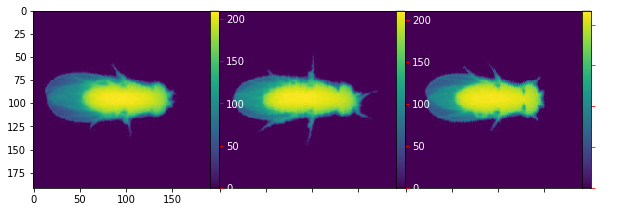

(<Figure size 720x720 with 6 Axes>,
 <mpl_toolkits.axes_grid1.colorbar.Colorbar at 0x7fefb33720f0>)

In [52]:
montage(ims0stk)

#### Create a DPK TG; create an APT TGTFR, both using no augmentation. Confirm that we read the identical ims/locs from both.

In [54]:
DSFAC = 2
SIGMA = 5
VALSPLIT = 0.0
GRAPHSCALE = 1
tg = dpk.TrainingGenerator(generator=dg,
                           downsample_factor=DSFAC,
                           use_graph=True,
                           shuffle=False,
                           sigma=SIGMA,
                           validation_split=VALSPLIT,
                           graph_scale=GRAPHSCALE,
                           random_seed=0)


/home/al/git/dpk/deepposekit/io/TrainingGenerator.py:176: UserWarning: `n_validation` is 0. Increase `validation_split` to use a validation set.
  "`n_validation` is 0. Increase `validation_split` to use a validation set."


In [ ]:
tgc = tg.get_config()
tgc

In [55]:
tg.train_range

array([   0,    1,    2, ..., 1497, 1498, 1499])

In [56]:
g = tg(n_outputs=1, batch_size=4, 
       validation=False, confidence=True)
g

In [57]:
import util
util.dictdiff(vars(tg),vars(g))

0 keys in d1 not in d2: set()
0 keys in d2 not in d1: set()
generator: values differ, <deepposekit.io.DataGenerator.DataGenerator object at 0x7fefbd1d33c8> vs <deepposekit.io.DataGenerator.DataGenerator object at 0x7fefb32fae48>
30 total common keys checked


In [61]:
train_tf

'/dat0/apt/cache/leap_dset/dpkfly/view_0/dpkfly/train_TF.tfrecords'

In [60]:
conf.dpk_input_sigma

5.0

In [63]:
dg.graph, dg.swap_index, dg.compute_image_shape()

(array([-1,  0,  0,  0,  3,  4, -1,  6,  7,  8, -1, 10, 11, 12, -1, 14, 15,
        16, -1, 18, 19, 20, -1, 22, 23, 24, -1, 26, 27, 28,  3,  3],
       dtype=int32),
 array([-1,  2,  1, -1, -1, -1, 18, 19, 20, 21, 22, 23, 23, 25, 26, 27, 28,
        29,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 31, 30],
       dtype=int32),
 (192, 192, 1))

In [8]:
conf.img_dim = 1  # hack, the leap stripped lbl has NumChans=3, but we created the tfr 
                  # directly using the dpk h5 which is 1-channel
conf = apt_dpk.update_conf_dpk(conf,
                               dg.graph,
                               dg.swap_index,
                               n_keypoints=dg.n_keypoints,
                               imshape=dg.compute_image_shape(),
                               useimgaug=False,
                               imgaugtype=None)
vars(conf)         

{'rescale': 1.0,
 'label_blur_rad': 3.0,
 'batch_size': 8,
 'view': 0,
 'gamma': 0.1,
 'display_step': 50,
 'num_test': 24,
 'dl_steps': 60000,
 'decay_steps': 25000,
 'learning_rate': 0.0001,
 'trx_align_theta': False,
 'horz_flip': False,
 'vert_flip': False,
 'brange': [-0.1, 0.1],
 'crange': [0.9, 1.1],
 'rrange': 15.0,
 'trange': 10.0,
 'scale_range': 0.2,
 'scale_factor_range': 1.1,
 'use_scale_factor_range': False,
 'imax': 255.0,
 'check_bounds_distort': True,
 'adjust_contrast': False,
 'clahe_grid_size': 20,
 'normalize_img_mean': False,
 'normalize_batch_mean': False,
 'perturb_color': False,
 'flipLandmarkMatches': {},
 'learning_rate_multiplier': 1.0,
 'splitType': 'frame',
 'trainfilename': 'train_TF',
 'fulltrainfilename': 'fullTrain_TF',
 'valfilename': 'val_TF',
 'valdatafilename': 'valdata',
 'valratio': 0.3,
 'holdoutratio': 0.8,
 'max_n_animals': 1,
 'flipud': False,
 'unet_rescale': 1.0,
 'unet_keep_prob': 1.0,
 'unet_use_leaky': False,
 'use_pretrained_weights': T

In [9]:
tgtfr = TGTFR.TrainingGeneratorTFRecord(conf)

W0504 21:41:43.607233 140621742061376 tfdatagen.py:571] tfdatagen makedatagen: /dat0/apt/cache/leap_dset/dpkfly/view_0/dpkfly/train_TF.tfrecords, distort/shuf=True/True, ppfun=ims_locs_preprocess_dpk, {'infinite': True, 'debug': True}
W0504 21:41:43.636540 140621742061376 tfdatagen.py:503] tfdatagen data gen. file=/dat0/apt/cache/leap_dset/dpkfly/view_0/dpkfly/train_TF.tfrecords, distort/shuf=True/True, ppfun=ims_locs_preprocess_dpk, N=1500
/dat0/venv/env/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [70]:
c0 = tg.get_config()
c1 = tgtfr.get_config()
util.dictdiff(c0,c1)

7 keys in d1 not in d2: {'generator', 'sigma', 'validation_split', 'n_samples', 'shuffle', 'datapath', 'dataset'}
0 keys in d2 not in d1: set()
random_seed: values differ, 0 vs None
n_validation: values differ, 0 vs 1500
12 total common keys checked


In [69]:
c0

{'n_train': 1500,
 'n_validation': 0,
 'validation_split': 0.0,
 'downsample_factor': 2,
 'output_shape': (48, 48),
 'n_output_channels': 66,
 'shuffle': False,
 'sigma': 5,
 'output_sigma': 1.25,
 'use_graph': True,
 'graph_scale': 1,
 'random_seed': 0,
 'augmenter': False,
 'datapath': '/home/al/git/dpkd/datasets/fly/annotation_data_release.h5',
 'dataset': 'images',
 'generator': 'DataGenerator',
 'n_samples': 1500,
 'image_shape': (192, 192, 1),
 'keypoints_shape': (32, 2)}

In [71]:
def xylist2xyarr(xylist, xisscalarlist=False):
    x, y  = zip(*xylist)
    if xisscalarlist:
        assert all([len(z)==1 for z in x])
        x = [z[0] for z in x]
    x = np.concatenate(x,axis=0)
    y = np.concatenate(y,axis=0)
    return x, y
    

In [72]:
# For tg, originally we constructed without any aug,
# and with VALSPLIT=0. So we will use the training imgs
# to get unaugmented ims
g = tg(n_outputs=1, batch_size=4, 
       validation=False, confidence=True)

In [75]:
# For tgtfr
# 1. we did not have a val db, so it will use the trndb
# 2. validation=True =>  no distort/aug/shuffle.
conf.batch_size = 4 # hack again, note tgtfr uses batch_size in conf and ignores input arg
gtf = tgtfr(n_outputs=1, batch_size=4, 
       validation=True, confidence=True)

W0504 16:20:29.507585 140670850795328 TrainingGeneratorTFRecord.py:221] Ignoring batch specification of 4, conf batchsize is 4
W0504 16:20:29.509460 140670850795328 tfdatagen.py:571] tfdatagen makedatagen: /dat0/apt/cache/leap_dset/dpkfly/view_0/dpkfly/train_TF.tfrecords, distort/shuf=False/False, ppfun=ims_locs_preprocess_dpk, {'infinite': True}


In [74]:
imstgts_dpk = [g[x] for x in range(2)]
imsdpk, tgtsdpk = xylist2xyarr(imstgts_dpk)
imsdpk.shape, tgtsdpk.shape

((8, 192, 192, 1), (8, 48, 48, 66))

In [76]:
imstgts_apt = [next(gtf) for _ in range(2)]
imsapt, tgtsapt = xylist2xyarr(imstgts_apt, xisscalarlist=True)
imsapt.shape, tgtsapt.shape

W0504 16:20:36.000483 140670850795328 tfdatagen.py:503] tfdatagen data gen. file=/dat0/apt/cache/leap_dset/dpkfly/view_0/dpkfly/train_TF.tfrecords, distort/shuf=False/False, ppfun=ims_locs_preprocess_dpk, N=1500
/dat0/venv/env/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


((8, 192, 192, 1), (8, 48, 48, 66))

In [78]:
np.allclose(imsdpk, imsapt), np.allclose(tgtsdpk, tgtsapt)

(True, True)

In [79]:
np.array_equal(imsdpk, imsapt), np.array_equal(tgtsdpk, tgtsapt)

(False, True)

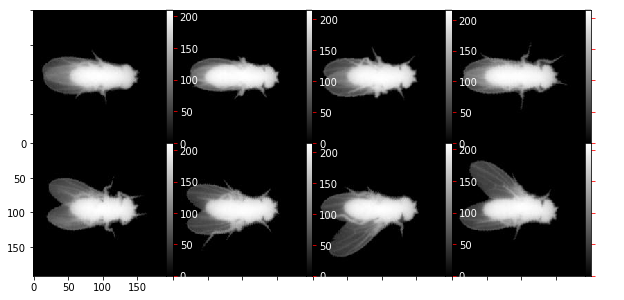

In [83]:
imsdpkstk = np.moveaxis(imsdpk,0,-1)
imsdpkstk = imsdpkstk[:,:,0,:]
hfig, grid, cb0 = montage(imsdpkstk,cmap='gray')

#### Create a TG with our default imgaug; v similar to DPK example notebook3; 
#### Create a TGTFR with ". Reseed each IA, can we get reproducible augmented data?

In [85]:
ia = apt_dpk.make_imgaug_augmenter('dpkfly', dg)

In [92]:
DSFAC = 2
SIGMA = 5
VALSPLIT = 0.0
GRAPHSCALE = 1
tg = dpk.TrainingGenerator(generator=dg,
                           downsample_factor=DSFAC,
                           augmenter=ia,
                           use_graph=True,
                           shuffle=False,
                           sigma=SIGMA,
                           validation_split=VALSPLIT,
                           graph_scale=GRAPHSCALE,
                           random_seed=0)

# For tg, VALSPLIT=0 => use the training imgs
g = tg(n_outputs=1, batch_size=4, 
       validation=False, confidence=True)

RNGSEED = 17
g.augmenter.reseed(RNGSEED)
imstgts_dpk = [g[x] for x in range(3)]
imsdpk, tgtsdpk = xylist2xyarr(imstgts_dpk)
imsdpk.shape, tgtsdpk.shape

/home/al/git/dpk/deepposekit/io/TrainingGenerator.py:176: UserWarning: `n_validation` is 0. Increase `validation_split` to use a validation set.
  "`n_validation` is 0. Increase `validation_split` to use a validation set."


((12, 192, 192, 1), (12, 48, 48, 66))

In [93]:
# Create a TGTFR with our default imgaug
conf.img_dim = 1
conf = apt_dpk.update_conf_dpk(conf,
                               dg.graph,
                               dg.swap_index,
                               n_keypoints=dg.n_keypoints,
                               imshape=dg.compute_image_shape(),
                               useimgaug=True,
                               imgaugtype='dpkfly')
tgtfr = TGTFR.TrainingGeneratorTFRecord(conf)
tgtfr.conf.dpk_augmenter.reseed(RNGSEED)
conf.batch_size = 4 # hack again, note tgtfr uses batch_size in conf and ignores input arg
gtf = tgtfr(n_outputs=1, batch_size=4, 
       validation=False, confidence=True, shuffle=False)

imstgts_apt = [next(gtf) for _ in range(3)]

imsapt, tgtsapt = xylist2xyarr(imstgts_apt, xisscalarlist=True)
imsapt.shape, tgtsapt.shape

W0504 16:36:38.149872 140670850795328 tfdatagen.py:571] tfdatagen makedatagen: /dat0/apt/cache/leap_dset/dpkfly/view_0/dpkfly/train_TF.tfrecords, distort/shuf=True/True, ppfun=ims_locs_preprocess_dpk, {'infinite': True, 'debug': True}
W0504 16:36:38.192239 140670850795328 tfdatagen.py:503] tfdatagen data gen. file=/dat0/apt/cache/leap_dset/dpkfly/view_0/dpkfly/train_TF.tfrecords, distort/shuf=True/True, ppfun=ims_locs_preprocess_dpk, N=1500
W0504 16:36:39.207124 140670850795328 TrainingGeneratorTFRecord.py:221] Ignoring batch specification of 4, conf batchsize is 4
W0504 16:36:39.210299 140670850795328 tfdatagen.py:571] tfdatagen makedatagen: /dat0/apt/cache/leap_dset/dpkfly/view_0/dpkfly/train_TF.tfrecords, distort/shuf=True/False, ppfun=ims_locs_preprocess_dpk, {'infinite': True}
W0504 16:36:39.253763 140670850795328 tfdatagen.py:503] tfdatagen data gen. file=/dat0/apt/cache/leap_dset/dpkfly/view_0/dpkfly/train_TF.tfrecords, distort/shuf=True/False, ppfun=ims_locs_preprocess_dpk, N=1

((12, 192, 192, 1), (12, 48, 48, 66))

In [94]:
np.allclose(imsdpk,imsapt,), np.allclose(tgtsdpk, tgtsapt), \
np.array_equal(imsdpk, imsapt), np.array_equal(tgtsdpk, tgtsapt)

(True, True, True, True)

In [96]:
imsstk = np.moveaxis(imsdpk, 0, -1)
imsstk = imsstk[:,:,0,:]
imsstk.shape

(192, 192, 12)

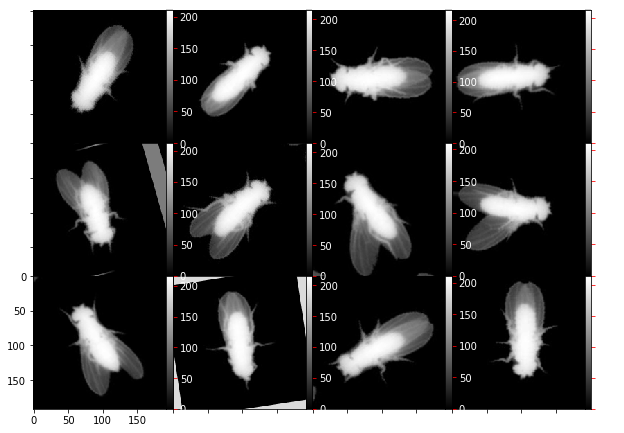

In [97]:
hfig, grid, cb0 = montage(imsstk,cmap='gray')

In [98]:
imsstk = np.moveaxis(imsapt, 0, -1)
imsstk = imsstk[:,:,0,:]
imsstk.shape

(192, 192, 12)

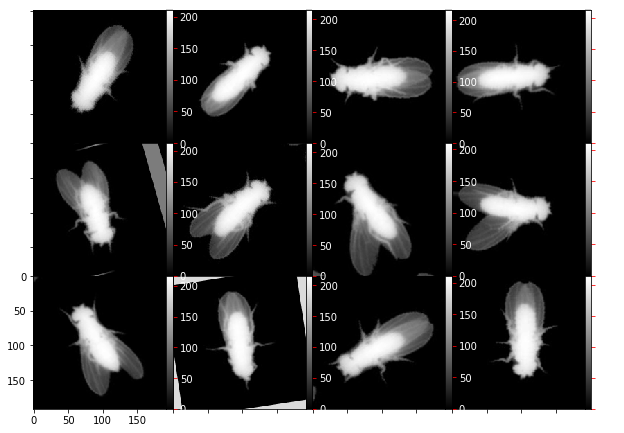

In [99]:
hfig, grid, cb0 = montage(imsstk,cmap='gray')

In [ ]:
## TODO: use pt for tgtfr. how does it compare?